# D212 PA 1 code - Doug Haunsperger

## Data Preparation

### Do initial package import and data read

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
    roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer

df = pd.read_csv('medical_clean.csv')

#view first 5 rows
df.head(5)

,CaseOrder,Customer_id,Interaction,UID,City,State,County,Zip,Lat,Lng,...,TotalCharge,Additional_charges,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8
0,1,C412403,8cd49b13-f45a-4b47-a2bd-173ffa932c2f,3a83ddb66e2ae73798bdf1d705dc0932,Eva,AL,Morgan,35621,34.34960,-86.72508,...,3726.702860,17939.403420,3,3,2,2,4,3,3,4
1,2,Z919181,d2450b70-0337-4406-bdbb-bc1037f1734c,176354c5eef714957d486009feabf195,Marianna,FL,Jackson,32446,30.84513,-85.22907,...,4193.190458,17612.998120,3,4,3,4,4,4,3,3
2,3,F995323,a2057123-abf5-4a2c-abad-8ffe33512562,e19a0fa00aeda885b8a436757e889bc9,Sioux Falls,SD,Minnehaha,57110,43.54321,-96.63772,...,2434.234222,17505.192460,2,4,4,4,3,4,3,3
3,4,A879973,1dec528d-eb34-4079-adce-0d7a40e82205,cd17d7b6d152cb6f23957346d11c3f07,New Richland,MN,Waseca,56072,43.89744,-93.51479,...,2127.830423,12993.437350,3,5,5,3,4,5,5,5
4,5,C544523,5885f56b-d6da-43a3-8760-83583af94266,d2f0425877b10ed6bb381f3e2579424a,West Point,VA,King William,23181,37.59894,-76.88958,...,2113.073274,3716.525786,2,1,3,3,5,3,4,3


### Selecting variables to answer research question

For possible explanatory variables, I am casting a wide net, looking at demographic info as well as reported medical conditions.

In [2]:
# Target variable
target='ReAdmis'
# Quantitative explanatory
quant_cols=['Population', 'Children', 'Age', 'Income', 'VitD_levels', 'Doc_visits', 'Full_meals_eaten']
# Categorical explanatory
cat_cols = ['Marital', 'Soft_drink', 'HighBlood', 'Complication_risk', 'Overweight', 'Arthritis', 'Diabetes', 'Hyperlipidemia', 
            'Stroke', 'BackPain', 'Anxiety', 'Allergic_rhinitis', 'Reflux_esophagitis', 'Asthma', 'Initial_admin']
ind_var_cols = quant_cols + cat_cols

### Check for outliers

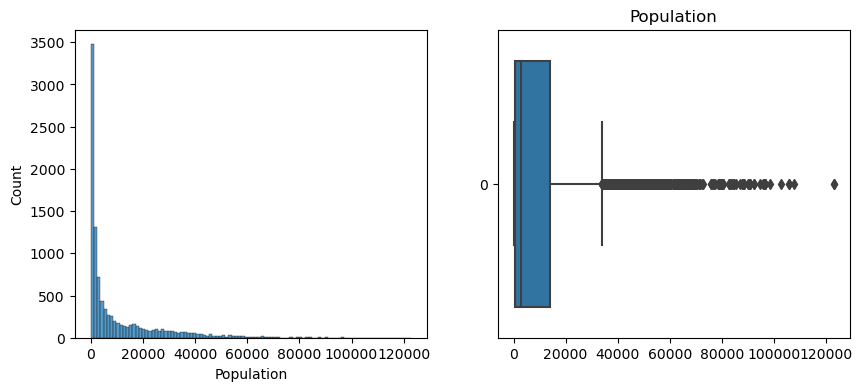

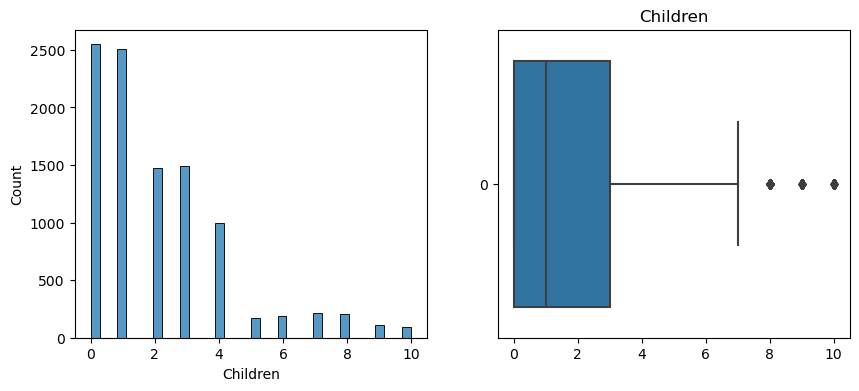

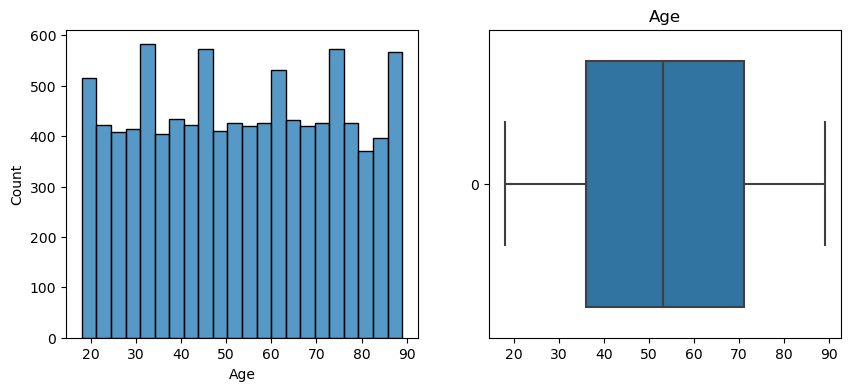

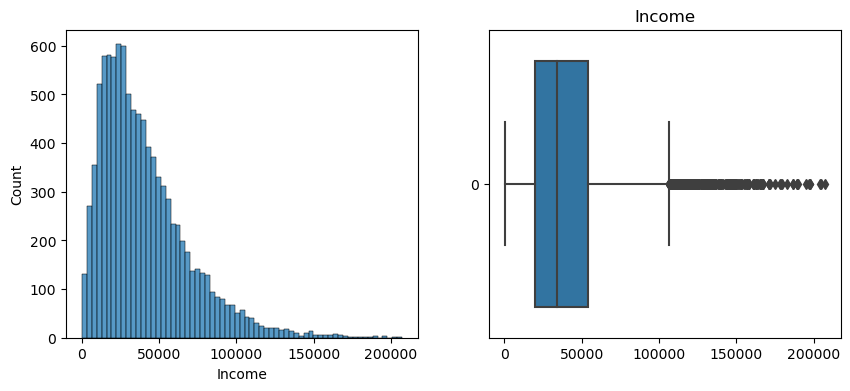

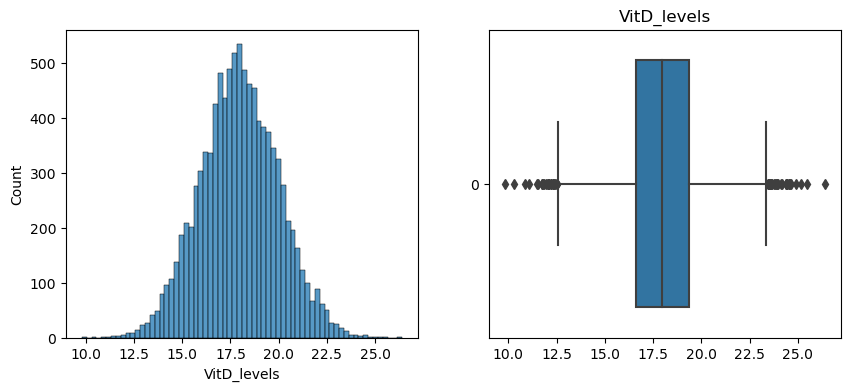

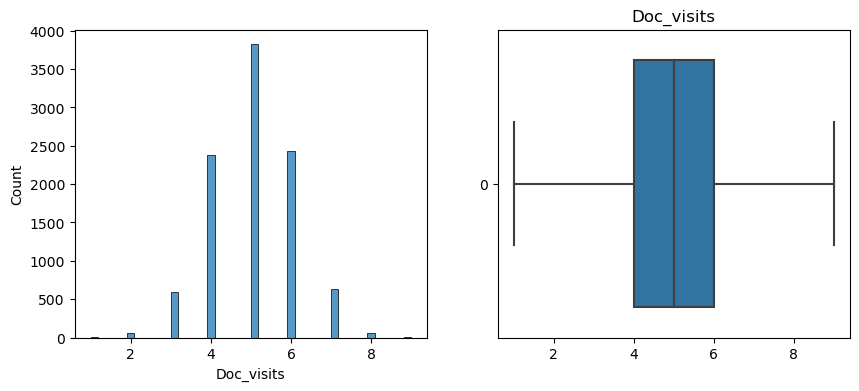

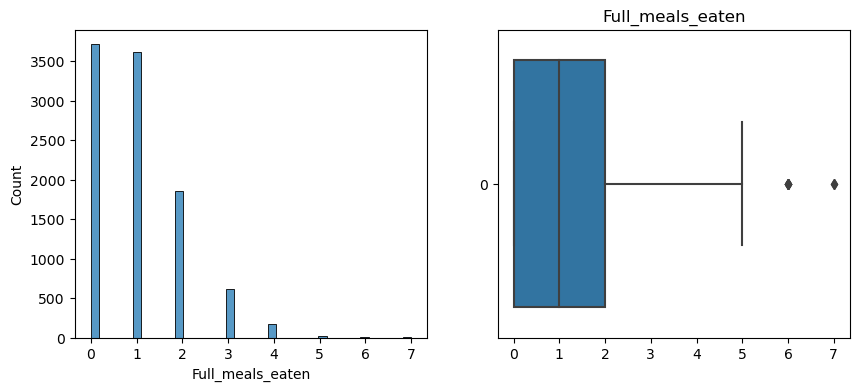

In [3]:
# Choose only the quantitative columns

# Ref: https://stackoverflow.com/questions/16392921/make-more-than-one-chart-in-same-ipython-notebook-cell (Kassies, 2013)
for col in quant_cols:
    fig, axs = plt.subplots(1,2, figsize=(10,4))
    sns.histplot(df[col], ax=axs[0])
    plt.title(col)
    sns.boxplot(df[col], orient='h', ax=axs[1])
    plt.title(col)
    plt.show()

### Treating Outliers
I will use the same treatment methodologies I did with the data in D208. In this case, I choose to retain all outliers except 0 values for `Population`.

#### Population
Population is reasonable to have a long-tail, right-skew distribution. However, zero values are not reasonable. They would also interfere with doing a log transformation if necessary.

In [4]:
df[(df.Population == 0)].shape

(109, 50)

Removing `Population == 0` outliers from the data set and move them to a separate data frame

In [5]:
pop_outliers = df[(df.Population == 0)]
df.drop(df[(df.Population == 0)].index, inplace=True)
df.shape

(9891, 50)

### Re-expressing Categorical Variables

In [6]:
# Split the data into features (X) and target (y)

# target variable dataframe
y = df[target].copy(deep=True)
# possible explanatory variables
X = df[ind_var_cols].copy(deep=True)

for col in cat_cols:
    print(df[col].unique())

['Divorced' 'Married' 'Widowed' 'Never Married' 'Separated']
['No' 'Yes']
['Yes' 'No']
['Medium' 'High' 'Low']
['No' 'Yes']
['Yes' 'No']
['Yes' 'No']
['No' 'Yes']
['No' 'Yes']
['Yes' 'No']
['Yes' 'No']
['Yes' 'No']
['No' 'Yes']
['Yes' 'No']
['Emergency Admission' 'Elective Admission' 'Observation Admission']


Set up dictionaries based on the above unique values in the data set. Code adapted from Larose & Larose (2019). `Marital` will be handled in the next code block.

In [7]:
dict_compl = {"Low": 1, "Medium": 2, "High": 3}
dict_yn = {"Yes": 1, "No": 0}
replace_dict = {'Soft_drink': dict_yn, 'HighBlood': dict_yn, 'Stroke': dict_yn, 'Complication_risk':dict_compl, 'Overweight': dict_yn,
                'Arthritis': dict_yn, 'Diabetes': dict_yn, 'Hyperlipidemia': dict_yn, 'BackPain': dict_yn, 'Anxiety': dict_yn, 
                'Allergic_rhinitis': dict_yn, 'Reflux_esophagitis': dict_yn, 'Asthma': dict_yn}
X.replace(replace_dict, inplace = True)
print(X.head())
y.replace(dict_yn, inplace = True)
y.head()

   Population  Children  Age    Income  VitD_levels  Doc_visits  \
0        2951         1   53  86575.93    19.141466           6   
1       11303         3   51  46805.99    18.940352           4   
2       17125         3   53  14370.14    18.057507           4   
3        2162         0   78  39741.49    16.576858           4   
4        5287         1   22   1209.56    17.439069           5   

   Full_meals_eaten   Marital  Soft_drink  HighBlood  ...  Arthritis  \
0                 0  Divorced           0          1  ...          1   
1                 2   Married           0          1  ...          0   
2                 1   Widowed           0          1  ...          0   
3                 1   Married           0          0  ...          1   
4                 0   Widowed           1          0  ...          0   

   Diabetes  Hyperlipidemia  Stroke  BackPain  Anxiety  Allergic_rhinitis  \
0         1               0       0         1        1                  1   
1         

0    0
1    0
2    0
3    0
4    0
Name: ReAdmis, dtype: int64

Set up dummy one-hot variables for `Marital` & `Initial_admin`. 
Per Dr. Middleton, using k-1 columns via the drop_first parameter in order to mitigate multicollinearity (2022). In this case, 'Divorced' is represented by 0's in all `Marital_*` columns. Similarly, 'Elective Admission' is represented by 0's in all `Initial_admin_*` columns.

In [8]:
X = pd.get_dummies(X, columns=['Marital', 'Initial_admin'], drop_first=True)
# replace column names in cat_cols list
cat_cols.remove('Marital')
cat_cols.remove('Initial_admin')
for col in ['Marital_Married', 'Marital_Never Married', 'Marital_Separated', 'Marital_Widowed', 
                'Initial_admin_Emergency Admission', 'Initial_admin_Observation Admission'] :
    cat_cols.append(col)
ind_var_cols = quant_cols + cat_cols


### Output clean data set

In [9]:
df_out = pd.concat([y, X], axis=1)

df_out.to_csv('clean_medical_data.csv', index=False)

### Split the data into training/testing; Scale quantitative variables

In [10]:
# Code ref: Datacamp tutorial (Shafl, 2023); WGU D206 Course material (Middleton, n.d., _PCA_).

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4877)
# Copy full X for scaling
X_all = X.copy(deep=True)

# Scale only the quantitative features using StandardScaler / ColumnTransformer
# code ref: scikit-learn User Guide, section 6.1.4

#print(X_train.info())
scaler = ColumnTransformer(
        [('scl', StandardScaler(), quant_cols)], remainder="drop")


#Transform training/test data
X_train[quant_cols] = scaler.fit_transform(X_train)
X_test[quant_cols] = scaler.transform(X_test)
X_all[quant_cols] = scaler.transform(X)

### Perform principal component analysis for dimensionality reduction

In [11]:
# PCA to reduce dimensionality prior to running KNN
pca = PCA()
pc = pca.fit_transform(X_train)

# column headers
pc_cols = []
for n in np.arange(0,len(X_train.columns)):
              pc_cols.append('PC'+str(n))
print(pc_cols)
pc_df = pd.DataFrame(pc, columns = pc_cols)

# Show explained variance per PC
print(pca.explained_variance_ratio_)



['PC0', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25']
[0.09422724 0.09188629 0.09031302 0.08910294 0.08837146 0.08596077
 0.08513394 0.0476473  0.03084729 0.02222506 0.0220618  0.02181056
 0.02108084 0.020248   0.019985   0.01944727 0.01872471 0.01831018
 0.01801276 0.0178005  0.0173059  0.01725133 0.01674179 0.01410238
 0.00789787 0.00350381]


#### Calculate eigenvalues

Raw Eigenvalues: 
 [1.05633438 1.03009107 1.01245393 0.99888842 0.99068813 0.95439391
 0.96366312 0.53414996 0.03927949 0.34581351 0.0885391  0.15809468
 0.24915398 0.24732372 0.24450727 0.23632667 0.18768382 0.19400778
 0.19339605 0.19955244 0.20193198 0.20526626 0.20991332 0.21801353
 0.22404179 0.22699013]
Percentage of Variance Explained by Each Component: 
 [0.09422724 0.09188629 0.09031302 0.08910294 0.08837146 0.08513394
 0.08596077 0.0476473  0.00350381 0.03084729 0.00789787 0.01410238
 0.02222506 0.0220618  0.02181056 0.02108084 0.01674179 0.0173059
 0.01725133 0.0178005  0.01801276 0.01831018 0.01872471 0.01944727
 0.019985   0.020248  ]


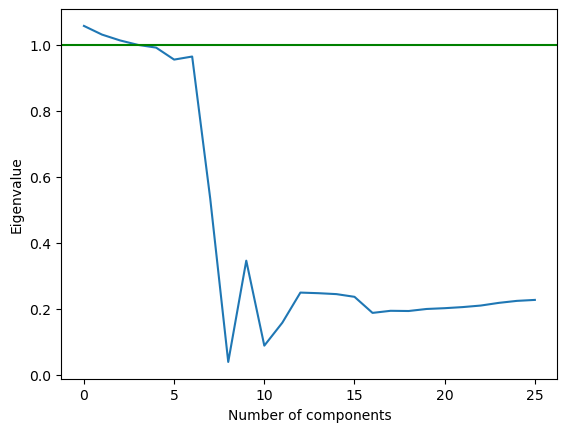

In [12]:

# Code reference: Getting Started with PCA (Middleton, n.d.); (Chuang, 2020).

cov_mat = np.cov(X_train.T)

# From this covariance matrix, caluclate the Eigenvalues and the Eigenvectors
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

# print the Eigenvalues
print("Raw Eigenvalues: \n", eigen_vals)
# the sum of the Eigenvalues 
print("Percentage of Variance Explained by Each Component: \n", eigen_vals/sum(eigen_vals))

plt.plot(eigen_vals)
plt.xlabel('Number of components')
plt.ylabel('Eigenvalue')
plt.axhline (y=1, color='green')
plt.show()


#### Plot explained variance per principal component

[0.09422724 0.18611353 0.27642655 0.36552949 0.45390095 0.53986173
 0.62499567 0.67264296 0.70349026 0.72571531 0.74777711 0.76958767
 0.79066851 0.8109165  0.8309015  0.85034877 0.86907347 0.88738366
 0.90539641 0.92319691 0.94050281 0.95775414 0.97449594 0.98859831
 0.99649619 1.        ]


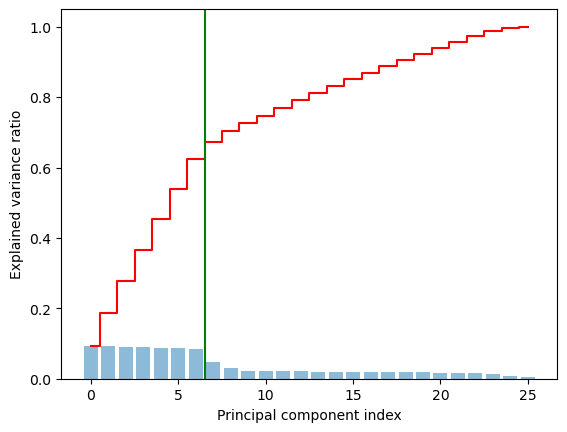

In [13]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)

plt.bar(range(0,len(eigen_vals)), var_exp, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(0,len(eigen_vals)), cum_var_exp, where='mid',
         label='Cumulative explained variance',
         color='red')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.axvline(x=6.5, color='green')
plt.show()

Choose to keep top 7 principal components

### Transform dataset using chosen PCs

In [14]:
pca = PCA(n_components=7)
pc_cols = []
for n in np.arange(0,7):
    pc_cols.append('PC'+str(n))
        
# PCA transform outputs just a numpy array - need to re-wrap in a DataFrame and maintain index values
X_train_pca = pd.DataFrame(pca.fit_transform(X_train), index=X_train.index, columns=pc_cols)
X_test_pca = pd.DataFrame(pca.transform(X_test), index=X_test.index, columns=pc_cols)
X_pca = pd.DataFrame(pca.transform(X_all), index=X_all.index, columns=pc_cols)


# Show loadings on each PC
loadings = pd.DataFrame(pca.components_, columns = X_train.columns, index = pc_cols)
#print(loadings)

In [15]:
print(X_train_pca.head())
y_train.head()

           PC0       PC1       PC2       PC3       PC4       PC5       PC6
2666 -1.333712 -0.053436 -0.482140  0.725938 -1.159914 -1.134545  0.500437
5901 -1.532281  0.247393 -1.376390  0.821114 -0.157225 -0.182612  1.530829
8768 -0.284370 -1.200460  1.923076  1.881452  2.206883  0.567922 -1.227506
2378  0.539659  1.184792 -0.228277 -1.552227 -0.896516  0.788355 -0.162882
7463  0.542380  0.616366 -0.313089 -0.718491  1.064125  0.384611 -1.187999


2666    0
5901    1
8768    0
2378    0
7463    1
Name: ReAdmis, dtype: int64

## Data Analysis

### KNN Fit & Evaluate

In [26]:
# Code ref: Datacamp tutorial (Shafl, 2023).

knn = KNeighborsClassifier(n_neighbors=49)
_=knn.fit(X_train_pca, y_train)

In [27]:
y_pred = knn.predict(X_test_pca)

acc = accuracy_score(y_test, y_pred)
print("Accuracy: ",acc) 

Accuracy:  0.6296109146033351


In [29]:
# Code ref: Datacamp tutorial (Shafl, 2023); StackOverflow ("piman", 2017)

k_values = [i for i in range (1,50,2)]
scores_acc = []
scores_f1 = []
scores_auc = []

scoring = {'acc': 'accuracy',
           'f1': 'f1',
           'auc': 'roc_auc'}
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_validate(knn, X_pca, y, scoring=scoring, cv=5)
    scores_acc.append(np.mean(score['test_acc']))
    scores_f1.append(np.mean(score['test_f1']))
    scores_auc.append(np.mean(score['test_auc']))
    


[0.5366499917485468, 0.5543411074114399, 0.5646542487831022, 0.5721356855680295, 0.5813368478222551, 0.5885151011812095, 0.5914471516136828, 0.5926609582619526, 0.6009506287198598, 0.605803453961234, 0.6090389432826273, 0.6112631058878589, 0.6110613923445929, 0.6119713002706375, 0.6138921261721278, 0.6151053708019136, 0.6201602161420906, 0.6214742664509197, 0.6228900931979926, 0.6242043478771795, 0.6252153680378044, 0.6262262349206609, 0.6268330616059116, 0.6257209292107063, 0.625720673747759] [0.36700573444448853, 0.3338510088974896, 0.2983309835094864, 0.27477134375551954, 0.25238037132530605, 0.22910320032013454, 0.20643773056854461, 0.18125716352328228, 0.1679958805130559, 0.15662521177081049, 0.14390266529861598, 0.13136715786172917, 0.12349903392096731, 0.111181313976938, 0.09695215151890194, 0.08907374265001547, 0.08972662138790163, 0.08461257179872839, 0.07535061286770858, 0.07561670940722838, 0.06788446903245401, 0.062384659362456706, 0.05674990499270781, 0.047361856403921807,

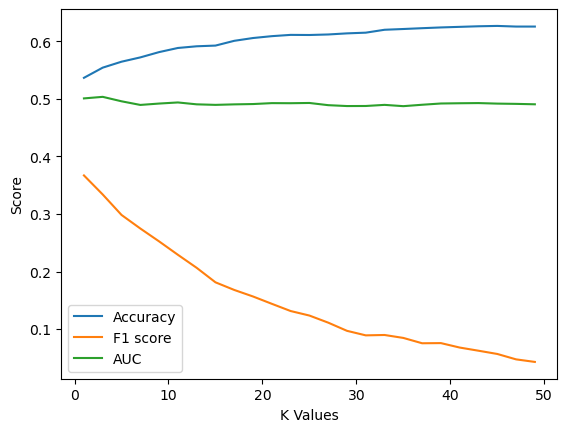

In [32]:
#Graph different scores vs number of K
sns.lineplot(x=k_values, y=scores_acc, errorbar=None)
sns.lineplot(x=k_values, y=scores_f1, errorbar=None)
sns.lineplot(x=k_values, y=scores_auc, errorbar=None)
plt.legend(labels=["Accuracy", "F1 score", "AUC"])
plt.xlabel("K Values")
plt.ylabel("Score")
print(scores_acc, scores_f1, scores_auc)

#### Choose best hyperparameter _k_

In [20]:
# Find best K based on AUC
best_index = np.argmax(scores_auc)
best_k = k_values[best_index]
print("Best K =",best_k)
knn = KNeighborsClassifier(n_neighbors=best_k)
_=knn.fit(X_train_pca, y_train)

Best K = 3


In [28]:
y_pred = knn.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC score:", auc)

Accuracy: 0.6296109146033351
Precision: 0.4576271186440678
Recall: 0.03708791208791209
F1 Score: 0.06861499364675985
AUC score: 0.5057541878585045


### Plot ROC curve for model

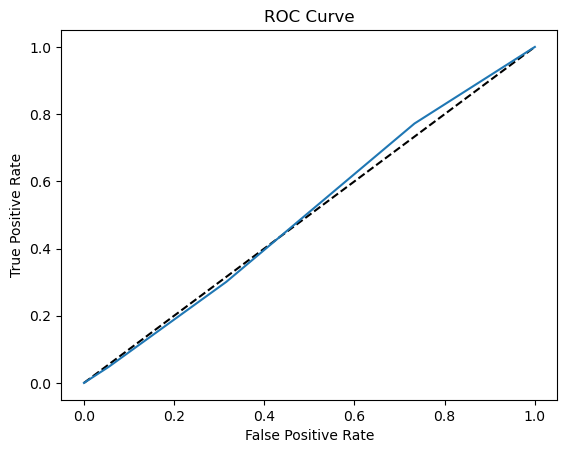

In [22]:
# Code ref: Datacamp lesson (Mueller, n.d.)
y_pred_prob = knn.predict_proba(X_test_pca)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [23]:
cm=confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))

[[856 395]
 [509 219]]
              precision    recall  f1-score   support

           0       0.63      0.68      0.65      1251
           1       0.36      0.30      0.33       728

    accuracy                           0.54      1979
   macro avg       0.49      0.49      0.49      1979
weighted avg       0.53      0.54      0.53      1979



### Confusion matrix heatmap

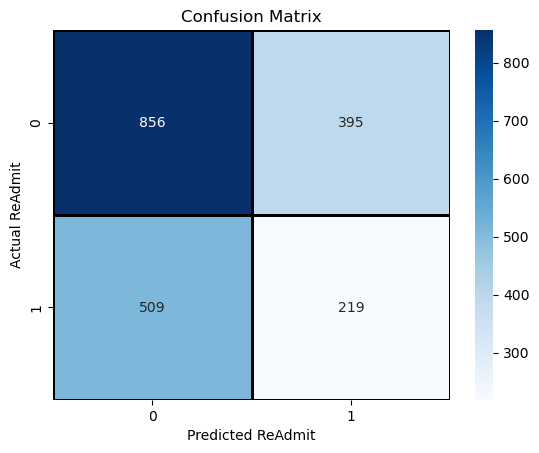

In [24]:
ax = sns.heatmap(cm,cmap='Blues', annot=True, fmt='.5g', linecolor='black', linewidths=2)
ax.set(xlabel='Predicted ReAdmit', ylabel='Actual ReAdmit')
plt.title('Confusion Matrix')
plt.show()

In [25]:
# Output test / train data

df_train_out = pd.concat([y_train, pd.DataFrame(X_train_pca)], axis=1)
df_test_out = pd.concat([y_test, pd.DataFrame(X_test_pca)], axis=1)

_=df_train_out.to_csv('train_xform_medical_data.csv', index=False)
_=df_test_out.to_csv('test_xform_medical_data.csv', index=False)
_=loadings.to_csv('PC_loadings.csv', index=True)